# Tensor Network Algorithm that allows to solve QUDO problems using matrices and introduces the waterfall effect

Author: Sergio Muñiz subiñas 

Date: 07/20/2025

Company: ITCL

Contact: sergio.muniz@itcl.es

This notebook implements a tensor network algorithm to solve QUDO, QUBO problems with a fixed number of neighbors $1$, the algorithm employs the MeLoCoTN methodology (https://arxiv.org/abs/2502.05981), a quantum inspired tensor network technique based on signal method and imaginary time evolution. 

This implementation is based on a matrix-vector implementation and it introduces the waterfall effect for a 1-neighbor QUDO problem proposed in the paper. The library used to perform the manipulation and contraction of the tensors is Numpy.

A detailed explanation of the algorithm is presented in the following paper.


In [2]:
# Libraries
import numpy as np
from qudo_solver.qudo_solver_core.qubo_solvers import ortools_qudo_solver
from qudo_solver.qudo_solver_core.qubo_auxiliar_functions import  generate_k_qubo, normalize_list_of_lists, qubo_value_from_lists, qudo_evaluation, qubo_list_to_matrix
from itertools import product
from time import time
from scipy.sparse import diags, csr_matrix, coo_matrix
%load_ext autoreload
%autoreload 2


---
# Tensor Network functions

## Definition of the Tensor Network nodes

In [3]:
def node_0(Q_matrix_0: float, dits: int, tau: float)-> csr_matrix:
    """
    Matrix that represents the row of tensors of the first variable.

    Args:
        Q_matrix_0 (float): Q_matrix[0][0].
        dits (int): dinary description: bits, trits,...
        tau (float): parameter of the imaginary time evolution.

    Returns:
        tensor (csr_matrix): tensor of the first node
    """
    diagonal_values = np.exp(-tau * Q_matrix_0 * np.arange(dits)**2)
    tensor = diags(diagonal_values, offsets=0, format='csr')
    
    return tensor

def node_grow(Q_matrix_row: np.array, dits: int, n_neight, tau: float):
    """
    Template that generates the matrix that represents the row of tensors of the variables with fewer neighbors than k from above.

    Args:
        Q_matrix_row (np.array): Q_matrix[row]
        dits (int): dinary description: bits, trits,...
        n_neight (_type_): maximum number of neighbors of the problem.
        tau (float): parameter of the imaginary time evolution.

    Returns:
        tensor (np.ndarray): Matrix of a variable with fewer neighbors above than below.
    """
    tensor = np.zeros((dits**n_neight, dits**(n_neight+1)))

    combinations_up = product(range(dits), repeat=n_neight)
    
    for element in combinations_up:
        index_up = sum(dits**aux * element[aux] for aux in range(n_neight))
        
        for index_last in range(dits):
            index_down = index_up + dits**n_neight * index_last
            full_element = list(element) + [index_last]
            
            # Calculate the tensor value
            value = 1.0
            for aux in range(len(full_element)):
                value *= np.exp(-tau * Q_matrix_row[aux] * full_element[-1] * full_element[aux])

            # Assign the computed value to the tensor
            tensor[index_up, index_down] = value
    
    return tensor

def node_intermediate(Q_matrix_row: np.ndarray, dits: int, n_neigh: int, tau: float):
    """
   Function that builds a sparse matrix (CSR) of shape (dits**n_neigh, dits**n_neigh) fully vectorized that represents the row of tensors of the variables with equal number of neighbors above and below.

    Parameters:
    Q_matrix_row (np.ndarray): 1D array with length n_neigh + 1; last entry is the quadratic coefficient.
    dits (int): dinary description: bits, trits, ...
    n_neigh (int) : Number of neighbor variables considered in the problem
    tau (float): parameter of the imaginary time evolution.

    Returns:
    scipy.sparse.csr_matrix
        The sparse matrix in CSR format.
    """
    size = dits ** n_neigh
    n_blocks = dits ** (n_neigh - 1)
    digits = np.array(np.unravel_index(np.arange(size), (dits,) * n_neigh)).T  

    Q_lin = Q_matrix_row[:n_neigh][::-1]             
    S = digits @ Q_lin                                

    k = np.arange(dits)                              
    Q_last = Q_matrix_row[-1]
  
    exponents = (S[:, None] * k[None, :]) + (Q_last * (k ** 2))[None, :]
    data_mat = np.exp(-tau * exponents)            

    rows = np.repeat(np.arange(size), dits)          
    base = (np.arange(size) // dits)                
    cols = (base[:, None] + k[None, :] * n_blocks).ravel(order="C")

    data = data_mat.ravel(order="C")
    A = coo_matrix((data, (rows, cols)), shape=(size, size)).tocsr()
    return A  

def last_tensor(Q_matrix_row: np.array, dits: int, tau:float):
    """
        Function that generates the vector that represents the row of nodes of the last variable.

    Args:
        Q_matrix_row (np.array): Row of the Q matrix.
        dits (int): Dinary description (e.g., bits, trits, etc.).
        num_neight_updown (int): Number of neighbors both up and down.
        tau (float): Parameter for the imaginary time evolution.

    Returns:
    """
    n_neighbors = len(Q_matrix_row) - 1
    tensor_size = dits**n_neighbors
    tensor = np.zeros(tensor_size)
    
    # Generate all combinations of dits^n_neighbors
    combinations_up = product(range(dits), repeat=n_neighbors)
    
    for element in combinations_up:
        index_up = sum(dits**aux * element[aux] for aux in range(n_neighbors))
        
        for index_last in range(dits):
            full_element = list(element) + [index_last]
            # Compute the tensor value
            tensor_aux = 1.0
            for el in range(len(full_element)):
                tensor_aux *= np.exp(-tau * Q_matrix_row[el] * full_element[el] * full_element[-1])
            tensor[index_up] += tensor_aux
    
    return tensor



def new_initial_tensor(Q_matrix_row, dits: int, tau: float, dit_sol: int):
    """
    Constructs the initial tensor for a tensor network based on the given parameters.

    Args:
        Q_matrix_row (np.array): Row of the Q matrix.
        dits (int): Dinary description (e.g., bits, trits, etc.).
        tau (float): Parameter for the imaginary time evolution.
        dit_sol (int): The value of the last solution element.

    Returns:
        np.array: The constructed initial tensor.
    """
    size_1 = dits
    tensor = np.zeros((size_1, size_1))

    for dit in range(dits):
        tensor[dit][dit] = np.exp(-tau*(Q_matrix_row[0]*dit_sol*dit + Q_matrix_row[1]*dit**2))
    return tensor

## Tensor network generation

In [4]:
def tensor_network_generator(Q_matrix: np.array, dits: int, n_neighbors: int, tau: float):
    """
    Generates the tensor network for a given Q matrix and the parameters.

    Args:
        Q_matrix (np.array): The Q matrix representing the problem.
        dits (int): Dinary description (e.g., bits, trits, etc.).
        n_neighbors (int): Number of neighbors to consider.
        tau (float): Parameter for the imaginary time evolution.

    Returns:
        list: A list of tensors representing the tensor network.
    """
    n_variables = len(Q_matrix)
    intermediate_tensors = []

    # Generate the first node
    tensor = node_0(Q_matrix[0][0], dits, tau)

    intermediate_tensors.append(tensor)

    # Generate the intermediate nodes
    for variable in range(1, n_variables - 1):
        if variable < n_neighbors:
            tensor = node_grow(Q_matrix[variable], dits, variable, tau)
            
        else:  
            tensor = node_intermediate(Q_matrix[variable], dits, n_neighbors, tau)
        intermediate_tensors.append(tensor)

    # Generate the last tensor
    
    tensor = last_tensor(Q_matrix[-1], dits, tau)
    intermediate_tensors.append(tensor)

    return intermediate_tensors

## Conexion and contraction of the Tensor Network

In [5]:
def waterfall_function(solution_list: list, tensor: np.ndarray, Q_matrix_row: np.ndarray, dits: int, tau: float):
    aux_solutions = []
    for i in range(dits):
        new_tensor_1 = new_initial_tensor(Q_matrix_row, dits, tau, i)
        sol = int(np.argmax(abs(new_tensor_1 @ tensor)))
        aux_solutions.append(sol)

    if solution_list == []:
        solution_list.append(aux_solutions)
        return solution_list 

    if equal_list(aux_solutions) == True:
        solution_list =  waterfall_post(solution_list, int(aux_solutions[0]))
        solution_list.append(aux_solutions[0])
        return solution_list
    else:
        solution_list.append(aux_solutions)
        return solution_list

def equal_list(list):
    return all(x == list[0] for x in list)

def waterfall_post(solution_list: list, aux_solution: int):
    for index in range(len(solution_list)-1, -1, -1):
        if isinstance(solution_list[index], list) and len(solution_list[index]) != 1:
            solution_list[index] = solution_list[index][aux_solution]
         
            aux_solution = solution_list[index]
        else: 
            return solution_list
    return solution_list

In [6]:
def tensor_network_contraction(tensor_list: list, Q_list: np.ndarray, dits: int, tau: float):
    """
    Performs the contraction of a tensor network by multiplying tensors sequentially.

    Args:
        tensor_list (list): A list of tensors representing the network.

    Returns:
        tuple: The final contracted tensor and a list of intermediate tensors.
    """
    # Initialize with the last tensor in the network
    tensor = tensor_list[-1]
    n_nodes = len(tensor_list)
    solution_list = []
    # Contract the tensors in reverse order
    waterfall_counts = 0
    for index, current_tensor in enumerate(reversed(tensor_list[1:-1])):
        Q_matrix_row = Q_list[n_nodes - index - 2]
        solution_list = waterfall_function(solution_list, tensor, Q_matrix_row, dits, tau)
        if type(solution_list[-1])  == int:
            waterfall_counts += 1
        tensor = current_tensor @ tensor  # Matrix multiplication
        tensor /= np.linalg.norm(tensor)  # Normalize the tensor after multiplication
        # if abs(tensor[0]) > 1e200:
        #     tensor = tensor / 1e200
    sol = np.argmax(abs(tensor_list[0] @ tensor))
    solution_list = waterfall_post(solution_list, sol)
    solution_list.append(sol)
    solution_list.reverse()
    # Reverse the list of intermediate tensors to maintain the order of contraction
    return solution_list, waterfall_counts/n_nodes

---
# General function

This function handles the overall process. It performs the minimization by iteratively solving each variable. The workflow consists of constructing the tensor network, contracting it, and determining the variable from the resulting vector.

In [7]:
def qubo_solver_matrix_waterfall(Q_matrix: list[list], tau: float, dits: int, n_neighbors: int) -> np.array:
    """
    Solves a QUBO (Quadratic Unconstrained Binary Optimization) problem using tensor network contraction.

    Args:
        Q_matrix (np.array): The Q matrix representing the QUBO problem.
        tau (float): The parameter for imaginary time evolution.
        dits (int): The number of digits (e.g., bits, trits, etc.).
        n_neighbors (int): The number of neighbors in the problem.

    Returns:
        np.array: The solution vector to the QUBO problem.
    """
    # Initialize variables and create a copy of the Q matrix

    if len(Q_matrix[-1]) != 2:
        print("Error: The QUDO problem has more than 1 neighbor")
        return None
    n_variables = len(Q_matrix)
    solution = np.zeros(n_variables, dtype=int)

    # Generate the tensor network
    tensor_network = tensor_network_generator(Q_matrix, dits, n_neighbors, tau)

    # Perform the tensor network contraction
    solution, waterfall_prob = tensor_network_contraction(tensor_network, Q_matrix, dits, tau)
    solution.append(0)
    cost = qubo_value_from_lists(solution, Q_matrix)
    solution2 = solution.copy()
    for dit in range(1, dits):
        solution2[-1] = dit
        cost2 = qubo_value_from_lists(solution2, Q_matrix)
        # If a better solution is found, update the solution and cost
        if cost2 < cost:
            solution[-1] = dit
            cost = cost2

    return solution, waterfall_prob


# Algorithm Testing and Ortools comparation

In [8]:
n_variables = 1000
n_neihbors = 1
dits = 3
tau = 10
seed = 174
# Generation of a random instance
Q_matrix_list = generate_k_qubo(n_variables, n_neihbors, seed)
Q_matrix_list = normalize_list_of_lists(Q_matrix_list)


#TN
initial_time = time()
solution, waterfall_prob = qubo_solver_matrix_waterfall(Q_matrix_list, tau, dits, n_neihbors)
print("Tensor network method time", time() - initial_time)
#print('Solution TN:     ', str(solution))
print('Tensor network cost:     ', qubo_value_from_lists(solution, Q_matrix_list))

#Ortools
Q_matrix = qubo_list_to_matrix(Q_matrix_list)
initial_time = time()
solution = ortools_qudo_solver(Q_matrix, dits, time = 10)
print("Ortools method time", time() - initial_time)
# print('Solution Ortools:     ', str(solution))
print('Ortools cost:     ', qudo_evaluation(Q_matrix, solution))
print("")



Tensor network method time 0.10136604309082031
Tensor network cost:      -50.759758682636516
Ortools method time 10.370638847351074
Ortools cost:      -51.46531395629634



# Experimentation

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def plot_function(data_1, data_2, axes_x_name, axes_y_name, color = 'blue', marker ='o', title = None, label = None, format='pdf'):
    plt.figure("figura")
    plt.plot(data_1, data_2, marker = marker, linestyle = '-', color = color, label = label)
    #plt.axhline(y=0, color='gray', linestyle='--', linewidth=3)
    plt.xlabel(axes_x_name)
    plt.ylabel(axes_y_name)
    #plt.yscale("exp")
    plt.tight_layout()
    plt.legend()
    plt.savefig(title, format=format, dpi=300)

In [11]:


def waterfall_experiment_function(max_dits: int, n_variables: int, repetitions: int):
    waterfall_list = []
    dit_list = []
    for dit in range(2, max_dits + 1):
        print("dit", dit)
        dit_list.append(dit)
        wat_aux = []
        for _ in range(repetitions):
            seed = None
            Q_matrix_list = generate_k_qubo(n_variables, 1, seed)
            Q_matrix_list = normalize_list_of_lists(Q_matrix_list)
        
            # Try different tau values
            best_solution = None
            best_energy = float('inf')
            best_waterfall = None
    
            for tau_test in np.linspace(1, 2000, 100):
                solution_test, waterfall_test = qubo_solver_matrix_waterfall(Q_matrix_list, tau_test, dit, 1)
                energy = qubo_value_from_lists(solution_test, Q_matrix_list)
                if energy < best_energy:
                    best_energy = energy
                    best_solution = solution_test
                    best_waterfall = waterfall_test
                    
        waterfall_prob = best_waterfall
        wat_aux.append(waterfall_prob)
        waterfall_list.append(np.mean(wat_aux))

    return dit_list, waterfall_list


In [ ]:
n_variables = 200
max_dits = 20
repetitions = 50
dit_list, waterfall_list = waterfall_experiment_function(max_dits,n_variables, repetitions)


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.705, 0.625, 0.665, 0.705, 0.645, 0.61, 0.545, 0.555, 0.645, 0.635, 0.685, 0.64, 0.645, 0.635, 0.59, 0.58, 0.615, 0.6, 0.595]


C:\Users\sergio.muniz\AppData\Local\Temp\ipykernel_21684\1370703954.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


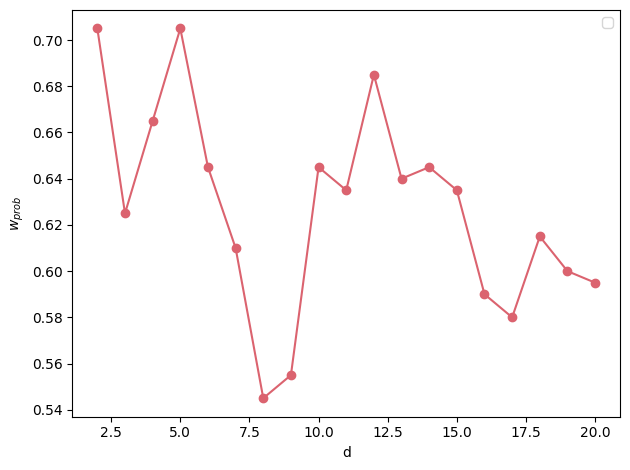

In [13]:

print(dit_list)
print(waterfall_list)
plot_function(dit_list, waterfall_list, r"d", r"$w_{prob}$", title = "paper_graphs/dit-waterfall_probability.pdf", color = '#db636f')